<a href="https://colab.research.google.com/github/MAHA06/ThesisOulu/blob/master/Adversarials/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# from google.colab import drive
# drive.mount(‘/content/gdrive’)

In [23]:
import math
# from torch.autograd.gradcheck import zero_gradients
from cw2 import carlini_wagner_l2
import seaborn as sns
from torch.autograd import Variable
import torch as torch
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from sklearn.metrics import plot_confusion_matrix

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from os.path import exists
np.random.seed(42) 
torch.manual_seed(42)
from sklearn.metrics import confusion_matrix
import pickle
import matplotlib.pyplot as plt
from torchvision.utils import save_image


In [24]:
online=True

img_size=(28,28)
num_classes=10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True) 
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [25]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.relu1=nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.relu2=nn.ReLU()
    self.max_p1=nn.MaxPool2d(2)
    self.dropout1 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(9216, 128)
    self.relu3=nn.ReLU()
    self.dropout2 = nn.Dropout2d(0.5)

    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.max_p1(x)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output




In [26]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using the device:",device)

Using the device: cuda


In [27]:
def fitModel(model,optimizer,scheduler,criterion,device,train_loader,val_loader,epochs):
  data_loader={'train':train_loader,'val':val_loader}
  print("Starting to fit the model")
  train_error,test_error=[],[]
  best_points=np.zeros(img_size+(num_classes,),dtype=float)
  best_scores=np.full(num_classes,-np.inf)
  print(best_scores[1])
  for epc in range(epochs):
    correct=0
    total=0
    loss_epoch,val_loss_epoch=0,0
    for phase in ('train','val'):

      for i,data in enumerate(data_loader[phase]):
        
        input,label=data[0].to(device),data[1].to(device)
        # print(input.shape)
        out=model(input)
        # print(out)
        loss=criterion(out,label)
        predict_label=torch.argmax(out,dim=1)
        out=out.squeeze().detach().cpu().numpy()
        if phase == 'train':
          optimizer.zero_grad()

          loss.backward()
          optimizer.step()
          loss_epoch+=loss.item()
          # print(predict_label.item(),label.item())
          # print(out[predict_label.item()],best_scores[predict_label.item()])
          # print(out)
          if epc == epochs-1 and predict_label.item()==label.item() and out[predict_label.item()]>best_scores[predict_label.item()]:#if last epoch and the predicted label is correct
            best_scores[predict_label.item()]=out[predict_label.item()]
            best_points[:,:,predict_label]=input.squeeze().detach().cpu().numpy()
            # print(label.item(),out[label.item()])
            # print("The scores were updated:",best_scores)
        else:
          total+=1
          if predict_label==label:
            correct+=1
          val_loss_epoch+=loss.item()
    scheduler.step(val_loss_epoch/len(val_loader))
    print("Epoch : {} Accuracy : {}".format(epc+1,correct/total))
    print("Epoch : {} Train Loss : {} Eval Loss : {}".format(epc+1,loss_epoch/len(train_loader),val_loss_epoch/len(val_loader)))
    train_error.append(loss_epoch)
    test_error.append(val_loss_epoch)
  
  return train_error,test_error,best_points,best_scores
        
          




In [28]:
model=Net().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


###############


In [29]:
## RUN THE TRAINING
if(online):
  loss,val_loss,best_points,best_scores=fitModel(model,optimizer,scheduler,criterion,device,train_loader,val_loader,10)


Starting to fit the model
-inf
Epoch : 1 Accuracy : 0.964
Epoch : 1 Train Loss : 0.2809719892321084 Eval Loss : 0.128770722931983
Epoch : 2 Accuracy : 0.9701
Epoch : 2 Train Loss : 0.10423331830941181 Eval Loss : 0.10985168561769815
Epoch : 3 Accuracy : 0.9737
Epoch : 3 Train Loss : 0.08361956042722628 Eval Loss : 0.0972270224800066
Epoch : 4 Accuracy : 0.9738
Epoch : 4 Train Loss : 0.07509999243824193 Eval Loss : 0.10857437730478077
Epoch : 5 Accuracy : 0.9755
Epoch : 5 Train Loss : 0.07197592142436217 Eval Loss : 0.09111496984005918
Epoch : 6 Accuracy : 0.9787
Epoch : 6 Train Loss : 0.06904799065136984 Eval Loss : 0.0804546673782918
Epoch : 7 Accuracy : 0.978
Epoch : 7 Train Loss : 0.06508825486573737 Eval Loss : 0.0860824036057809
Epoch : 8 Accuracy : 0.9786
Epoch : 8 Train Loss : 0.06186806568235564 Eval Loss : 0.08805693026180589
Epoch : 9 Accuracy : 0.9794
Epoch : 9 Train Loss : 0.05893609165296004 Eval Loss : 0.08759447784395318
Epoch : 10 Accuracy : 0.9779
Epoch : 10 Train Loss

(28, 28, 10)
tensor([[-41.0323, -39.5720, -29.8049,   0.0000, -35.3909, -18.7130, -50.9600,
         -25.5387, -22.6081, -16.8371]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor(3, device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


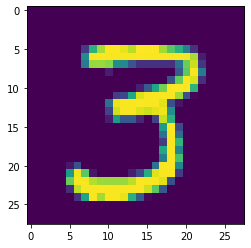

In [30]:
if online:
  print(best_points.shape)
  plt.imshow(best_points[:,:,3])
  v=torch.tensor(best_points[:,:,3].reshape(1,1,28,28),dtype=torch.float32)
  print(model(v.to(device)))
  print(torch.argmax(model(v.to(device))))
  print(best_scores)

In [31]:
if online:
  filename = './model_MNIST'
  pickle.dump(model, open(filename, 'wb'))
  filename = './model_MNIST_cpu'
  pickle.dump(model.cpu(), open(filename, 'wb'))
  filename = './scores.mf'
  best_markers={"b_p":best_points,"b_s":best_scores}
  pickle.dump(best_markers,open(filename,'wb'))

In [32]:
def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=50):

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        print("Using GPU")
        image = image.cuda()
        net = net.cuda()



    f_image = net.forward(image).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = pert_image
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [33]:
def JacobianMatrix(model,input):
  print("Input size ",input.shape)
  number_of_piels=input.shape[0]*input.shape[1]
  J = torch.zeros ((1, 784, 10))   # loop will fill in Jacobian
  input.requires_grad = True
  preds = model (input)
  for  i in range (10):
      grd = torch.zeros ((1, 10))   # same shape as preds
      grd[0, i] = 1    # column of Jacobian to compute
      preds.backward (gradient = grd, retain_graph = True)
      J[:,:,i] = input.grad   # fill in one column of Jacobian
      input.grad.zero_()   # .backward() accumulates gradients, so reset to zero
def JSM_attack(model, input):
  input.requires_grad=True

In [ ]:
activation_in = {}
activation_out={}
def get_activation_input(name):
    def hook(model, input, output):
        activation_in[name] = input[0]
    return hook
def get_activation_output(name):
    def hook(model, input, output):
        activation_out[name] = output.clone().detach()
    return hook
def nth_derivative(f, wrt, n):

    for i in range(n):

        grads = torch.autograd.grad(f, wrt, create_graph=True)[0]
        f = grads.sum()

    return grads
def get_higher_gradients(model,input,label, rank=3):
  grads=[]
  optimizer.zero_grad()
  input.requires_grad=True
  outs=model(input)
  # pred=torch.zeros(num_classes)
  # pred[label.item()]=1
  l=criterion(outs,label)
  aux=torch.autograd.grad(l,input,retain_graph=True,create_graph=True)[0]
  grads.append(aux.reshape(1,-1))
  for r in range(2,rank+1):
    aux=torch.autograd.grad(aux.sum(),input,create_graph=True)[0]
    grads.append(aux.reshape(1,-1))
  return grads
def check_taylor_prediction(model,input,marker_images,check_label,centered,layer_name,rank):
  # plt.imshow(input.squeeze().detach().cpu().numpy())
  # grads=get_higher_gradients(model,input,true_label)

  # grads=get_higher_gradients(model,input,perturbed_label)
  # layer_grads=get_layer_gradients(model,input,check_label,"conv2")

  # input=input.reshape(-1,1)
  # # marker_image=marker_images[:,:,true_label.item()].reshape(-1,1)
  # # marker_image=torch.tensor(marker_image,dtype=torch.float32)
  # # total=1.+torch.mm(grads[0],(input-marker_image))+torch.mm(grads[1],torch.pow((input-marker_image),2))/2
  # # total=1.+torch.mm(grads[0],(input-markerimage))+torch.mm(grads[1],torch.pow((input-marker_image),2))/2
  # marker_image1=marker_images[:,:,perturbed_label.item()].reshape(-1,1)
  # marker_image1=torch.tensor(marker_image1,dtype=torch.float32)
  # total1=torch.mm(layer_grads[0],(input-marker_image1))+torch.mm(layer_grads[1],torch.pow((input-marker_image1),2))/2
  marker_img=torch.tensor(marker_images[:,:,check_label.item()],device=device,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
  check_label_tns=torch.tensor(check_label,device=device)
  total=0
  if centered=="marker":
    total=compute_marker_image_prediction(model,input,marker_img,check_label_tns,layer_name,rank)
  else:
    total=compute_unknown_image_prediction(model,input,marker_img,check_label_tns,layer_name,rank)

  return total
  # return total_marker
def compute_marker_image_prediction(model,unk_image,marker_img,marker_label,l_name,rank):
  marker_img.requires_grad=True
  grads,input_marker,loss_marker=get_layer_gradients(model,marker_img,marker_label,l_name,rank)
  optimizer.zero_grad()
  input_marker=input_marker.view(-1,1)
  # print(input.shape)
  outs=model(unk_image)
  input_layer=activation_in[l_name].view(-1,1)
  total=loss_marker.item()
  for i in range(0,rank):
    total+=torch.mm(grads[i],torch.pow((input_layer-input_marker),i+1))/(math.factorial(i+1))
  return total.item()
def compute_unknown_image_prediction(model,unk_image,marker_image,marker_label,l_name,rank):

  grads,unk_input,loss_unk=get_layer_gradients(model,unk_image,marker_label,l_name,rank)
  optimizer.zero_grad()
  layer_input=unk_input.view(-1,1)
  # print(input.shape)
  outs=model(marker_image)
  input_layer=activation_in[l_name].view(-1,1)
  # total=loss_unk.item()
  total=0
  for i in range(0,rank):
    total+=torch.mm(grads[i],torch.pow((input_layer-layer_input),i+1))/(math.factorial(i+1))
  # total=loss_unk.item()+torch.mm(grads[0],(input_layer-layer_input))+torch.mm(grads[1],torch.pow((input_layer-layer_input),2))/2

  return total.item()

def get_layer_gradients(model,target_img,label,l_name, rank):
  grads=[]
  optimizer.zero_grad()
  # target_img.requires_grad=True
  outs=model(target_img)
  # pred=torch.zeros((1,num_classes),dtype=np.int)
  # pred[label.item()]=1
  loss_value=criterion(outs,label)
  layer_input_data=activation_in[l_name]
  # layer_input_data.requires_grad=True
  # loss_value.backward()
  aux=torch.autograd.grad(loss_value,layer_input_data,retain_graph=True,create_graph=True)[0]
  # aux=layer_input_data.grad
  grads.append(aux.reshape(1,-1))
  for r in range(1,rank):
    aux=torch.autograd.grad(aux.sum(),layer_input_data,create_graph=True)[0]
    grads.append(aux.reshape(1,-1))
  return grads,layer_input_data,loss_value

def get_marker_images(model,data_loader):
  best_points=np.zeros(img_size+(num_classes,),dtype=float)
  best_scores=np.full(num_classes,np.inf)
  for i,data in enumerate(data_loader):

      input,label=data[0].to(device),data[1].to(device)
      # print(input.shape)
      out=model(input)
      # print(out)
      loss=criterion(out,label)
      predict_label=torch.argmax(out,dim=1)
      out=out.squeeze().detach().cpu().numpy()

      if   predict_label.item()==label.item() and loss<best_scores[predict_label.item()]:#if last epoch and the predicted label is correct
        best_scores[predict_label.item()]=loss
        best_points[:,:,predict_label.item()]=input.squeeze().detach().cpu().numpy()
  best_markers={"b_p":best_points,"b_s":best_scores}
  return best_markers
if(device.type=="cpu"):
  filename = './model_MNIST_cpu'
else:
  filename="./model_MNIST"
model= pickle.load(open(filename, 'rb'))
filename = './scores.mf'
# best_fits=get_marker_images(model,train_loader)
# pickle.dump(best_fits, open(filename, 'wb'))
best_fits=0
if (exists(filename)) :
  best_fits=pickle.load(open(filename,'rb'))
else :
  best_fits=get_marker_images(model,train_loader)
  pickle.dump(best_fits, open(filename, 'wb'))

def compute_statistics(confusion_matrix):
  FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
  FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
  TP = np.diag(confusion_matrix)
  TN = confusion_matrix.sum() - (FP + FN + TP)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  print("Sensitivity",TPR)
  # Specificity or true negative rate
  TNR = TN/(TN+FP)
  print("Specificity",TNR)
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  print("Precision",PPV)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)
  print("ACC:",ACC)
def testModel(model,criterion,device,test_loader,attack,rank,centered,l_name):
  print("Running on ",device);
  print("Started testing with A:{} on L:{} with Rank:{} with the center:{}".format(attack,l_name,rank,centered))
  right=0
  totals=0
  fooled=0
  more_labels=0
  true_small=0
  binary=0
  true_min=0
  loss_e=0.02
  loser_count=0
  c_matrix_data=[]
  correct_samples=0
  number_samples=0
  normal_samples_taylor=0
  for data,labels in test_loader:
    number_samples+=1
   
    data,labels=data.to(device),labels.to(device)
    data.requires_grad=True
    ################
    taylors=range(0,num_classes)
    taylors=[check_taylor_prediction(model,data,best_fits['b_p'],torch.tensor(lab).reshape(1),centered,layer_name=l_name,rank=rank) for lab in taylors ]
    max_l=np.argmax(taylors)
    if(max_l==labels):
      normal_samples_taylor+=1
      ##################



    outs=model(data)
    
    true_preds=torch.argmax(outs,dim=1)
    if true_preds!=labels:
      continue
    correct_samples+=1
    epsilon=0.1
    true_loss=criterion(outs,labels)
    true_loss.backward()
    data_grad=data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    elif attack=="deepfool":
      perturbed_data=deepfool(data,model)[4]
    elif attack == "jacobian":
      print("Implement the jacobian")
    elif attack=="cw2":
      perturbed_data=carlini_wagner_l2(model,data,labels,max_iterations=80)
    p_out=model(perturbed_data)
    perturb_label=torch.argmax(p_out,dim=1)

    if perturb_label!=labels:
      totals+=1
      taylors=range(0,num_classes)
      taylors=[check_taylor_prediction(model,perturbed_data,best_fits['b_p'],torch.tensor(lab).reshape(1),centered,layer_name=l_name,rank=rank) for lab in taylors ]
      taylor_np=np.array(taylors)
      winning_labels=np.where((taylor_np>-5) )
     
      pert_loss=criterion(p_out, labels)
      abs_x=[abs(t) for t in taylors]
      max_l=np.argmax(taylors)
      min_l=np.argmin(abs_x)
      taylor_np[taylor_np<0]=np.inf
      true_min=np.argmin(taylor_np)
      smallest_indexs=np.array(abs_x).argsort()[:2]
      c_matrix_data.append([ labels.item(),max_l])
      if len([x if x>0. for x in taylor_np]):
        more_labels+=1
      if true_min==labels.item():
        true_small+=1
      if max_l == perturb_label.item():
        fooled_max+=1
      if max_l == labels.item():
        right+=1
     
      if min_l == labels.item():
        loser_count+=1
  
      print("Stats for attack type:"+attack +" on the layer:"+l_name+" with a gradient rank:"+str(rank))
      print("Normal taylor predictions",normal_samples_taylor/number_samples)
      print("More labels detected{}".format(more_labels/totals))
      print("Overall test accuracy:{}".format(correct_samples/number_samples))
      print("Right max :",right/totals)
      print("Fooled max:",fooled_max/totals)
      print("Right min :",loser_count/totals)
      print("True min:",true_small/totals)
      print("Binary ",binary/totals)
  confusion_array=np.array(c_matrix_data)
  cm =   confusion_matrix(confusion_array[:,0],confusion_array[:,1])
  compute_statistics(cm)
  f = sns.heatmap(cm, annot=True,fmt="d")
  plt.savefig('./Outs/heatMap-'+attack+'_'+l_name+'.png')
  plt.clf()
  return right/totals
# conv2
model.conv1.register_forward_hook(get_activation_input('conv1'))
model.conv2.register_forward_hook(get_activation_input('conv2'))
model.relu1.register_forward_hook(get_activation_input('relu1'))
model.relu1.register_forward_hook(get_activation_input('relu2'))
model.relu3.register_forward_hook(get_activation_input('relu3'))
model.fc1.register_forward_hook(get_activation_input('fc1'))
model.fc1.register_forward_hook(get_activation_input('fc2'))
model.relu3.register_forward_hook(get_activation_input('dropout1'))
model.relu3.register_forward_hook(get_activation_input('dropout2'))

print("Starting")
ranks=[3]
layers=["conv1","relu1","conv2","relu2","dropout1","fc1","relu3","dropout2","fc2"]
attack_types=["cw2","fgsm","deepfool","ifgsm"]
centers=["sample"]
all_results_filename="all_results.md"
all_results=np.zeros((len(ranks),len(layers)))
for c in centers:
  for att_i,att in enumerate(attack_types):
    for r_i,r in enumerate(ranks):
      acc_mifgsm=[]
      for l_i,l in enumerate(layers):
        t=testModel(model,criterion,device,test_loader,att,r,c,l_name=l)
        acc_mifgsm.append(t)
        all_results[r_i,l_i]=t
      plt.plot(layers,acc_mifgsm)
      plt.savefig('./Outs/{}_R{}.png'.format(att,r))
      plt.clf()
    attack_filename="./Outs/{}.md".format(att)
    pickle.dump(all_results, open(attack_filename, 'wb+'))




print("Done")

Starting
Running on  cuda
Started testing with A:cw2 on L:conv1 with Rank:3 with the center:sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Stats for attack type:cw2 on the layer:conv1 with a gradient rank:3
Normal taylor predictions 0.9516129032258065
Special stuff 0.0
Overall test accuracy:1.0
Right max : 1.0
Fooled max: 0.0
Right min : 1.0
True min: 0.0
Binary  0.0
Stats for attack type:cw2 on the layer:conv1 with a gradient rank:3
Normal taylor predictions 0.9266666666666666
Special stuff 0.0
Overall test accuracy:1.0
Right max : 0.5
Fooled max: 0.0
Right min : 0.5
True min: 0.5
Binary  0.0
Stats for attack type:cw2 on the layer:conv1 with a gradient rank:3
Normal taylor predictions 0.9140893470790378
Special stuff 0.0
Overall test accuracy:0.9896907216494846
Right max : 0.6666666666666666
Fooled max: 0.0
Right min : 0.3333333333333333
True min: 0.6666666666666666
Binary  0.0
Stats for attack type:cw2 on the layer:conv1 with a gradient rank:3
Normal taylor predictions 0.9157608695652174
Special stuff 0.0
Overall test accuracy:0.9864130434782609
Right max : 0.75
Fooled max: 0.0
Right min : 0.5
True min: 0.75
Binary  0.0

In [ ]:
!zip -r /content/file.zip /content/Outs
from google.colab import files
files.download("/content/file.zip")
